# CH04: Building Good Training Sets - Data Preprocessing

## Dealing with missing data

### Identifying missing alues in tabular data

In [1]:
import pandas as pd
from io import StringIO

In [2]:
csv_data = \
"""A,B,C,D,E
1.0,2.0,3.0,4.0,
5.0,6.0,,8.0,
10.0,11.0,12.0,
"""
df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D,E
0,1.0,2.0,3.0,4.0,NaN
1,5.0,6.0,NaN,8.0,NaN
2,10.0,11.0,12.0,NaN,NaN


In [3]:
df.isnull()

,A,B,C,D,E
0,False,False,False,False,True
1,False,False,True,False,True
2,False,False,False,True,True


In [4]:
df.isnull().sum()

A    0
B    0
C    1
D    1
E    3
dtype: int64

In [5]:
df.values

array([[  1.,   2.,   3.,   4.,  nan],
       [  5.,   6.,  nan,   8.,  nan],
       [ 10.,  11.,  12.,  nan,  nan]])

### Eliminating samples or features with missing values

In [6]:
df.dropna(axis=0) # drop rows with missing values

,A,B,C,D,E


In [7]:
df.dropna(axis=1) # drop columns with missing values

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [8]:
df.dropna(how="all", axis=1) # drop columns where all rows are NaN

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [9]:
df.dropna(thresh=3) # drop rows that have less than 3 real values

,A,B,C,D,E
0,1.0,2.0,3.0,4.0,NaN
1,5.0,6.0,NaN,8.0,NaN
2,10.0,11.0,12.0,NaN,NaN


In [10]:
df.dropna(subset=["C"]) # drop rows with NaN in specific columns

,A,B,C,D,E
0,1.0,2.0,3.0,4.0,NaN
2,10.0,11.0,12.0,NaN,NaN


### Imputing missing values

In [11]:
from sklearn.preprocessing import Imputer

imr = Imputer(missing_values="NaN", strategy="mean", axis=0)
imr = imr.fit(df.values)

In [12]:
imputed_data = imr.transform(df.values)
imputed_data

array([[  1. ,   2. ,   3. ,   4. ],
       [  5. ,   6. ,   7.5,   8. ],
       [ 10. ,  11. ,  12. ,   6. ]])

#### Imputer (http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html#sklearn.preprocessing.Imputer)

strategy : string, optional (default=”mean”)

    The imputation strategy.

        If “mean”, then replace missing values using the mean along the axis.
        If “median”, then replace missing values using the median along the axis.
        If “most_frequent”, then replace missing using the most frequent value along the axis.

## Handling categorical data

In [13]:
import pandas as pd

In [14]:
df = pd.DataFrame([
    [ "green", "M", 10.1, "class1" ],
    [ "red", "L", 13.5, "class2" ],
    [ "blue", "XL", 15.3, "class1" ]
])
df.columns = [ "color", "size", "price", "classlabel" ]

In [15]:
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
color         3 non-null object
size          3 non-null object
price         3 non-null float64
classlabel    3 non-null object
dtypes: float64(1), object(3)
memory usage: 176.0+ bytes


### Mapping ordinal features

In [17]:
size_mapping = {"XL": 3, "L": 2, "M": 1}
# map values of Series using input correspondence (which can be a dict, Series, or function)
df["size"] = df["size"].map(size_mapping)

In [18]:
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


### Encoding class labels

In [19]:
import numpy as np

In [20]:
class_mapping = {label: idx for idx, label in enumerate(np.unique(df["classlabel"]))}

In [21]:
df["classlabel_1"] = df["classlabel"].map(class_mapping)

In [22]:
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder()
y = class_le.fit_transform(df["classlabel"].values)
y

array([0, 1, 0])

In [23]:
class_le.inverse_transform(y)

array(['class1', 'class2', 'class1'], dtype=object)

In [24]:
df["classlabel"] = class_le.transform(df["classlabel"])

### Performing one-hot encoding on nominal features
#### OneHotEncoder vs pandas.get_dummies

In [25]:
X = df[["color", "size", "price"]].values

color_le = LabelEncoder()
X[:,0] = color_le.fit_transform(X[:,0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [26]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categorical_features=[0]) # column position of the variable that we want to transform
ohe.fit_transform(X).toarray() # ohe returns a sparse matrix, so we have to convert it to regular matrix

array([[  0. ,   1. ,   0. ,   1. ,  10.1],
       [  0. ,   0. ,   1. ,   2. ,  13.5],
       [  1. ,   0. ,   0. ,   3. ,  15.3]])

In [27]:
pd.get_dummies(df[["price", "color", "size"]])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


In [28]:
pd.get_dummies(df[["price", "color", "size"]], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


### Partitioning a dataset into separate training and test sets

In [29]:
from sklearn import datasets

wine = datasets.load_wine()

df_wine = pd.DataFrame(wine.data, columns=wine.feature_names)
df_wine["Class label"] = wine.target + 1 # add one to have the same values as in the book

In [30]:
df_wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Class label
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,1
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,1
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,1
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,1
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,1


In [31]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

### Bringing features onto the same scale

In [32]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
mms.fit(X_train)

X_train_norm = mms.transform(X_train)
X_test_norm = mms.transform(X_test)

In [33]:
X_train_norm

array([[ 0.64619883,  0.83201581,  0.4248366 , ...,  0.45744681,
         0.28571429,  0.19400856],
       [ 0.6871345 ,  0.15612648,  0.65359477, ...,  0.81914894,
         0.63369963,  0.68259629],
       [ 0.67836257,  0.15019763,  0.65359477, ...,  0.75531915,
         0.52747253,  0.71825963],
       ..., 
       [ 0.72222222,  0.84980237,  0.34640523, ...,  0.10638298,
         0.02197802,  0.09771755],
       [ 0.16081871,  0.06916996,  0.39215686, ...,  0.54255319,
         0.68131868,  0.43366619],
       [ 0.37719298,  0.61857708,  0.45751634, ...,  0.75531915,
         0.68131868,  0.13195435]])

In [34]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [35]:
X_train_std

array([[ 0.71225893,  2.22048673, -0.13025864, ..., -0.20017028,
        -0.82164144, -0.62946362],
       [ 0.88229214, -0.70457155,  1.17533605, ...,  1.33982592,
         0.54931269,  1.47568796],
       [ 0.84585645, -0.73022996,  1.17533605, ...,  1.06806189,
         0.1308109 ,  1.62934866],
       ..., 
       [ 1.02803489,  2.29746195, -0.5778911 , ..., -1.69487249,
        -1.86068037, -1.04434751],
       [-1.30384913, -1.08089484, -0.31677217, ...,  0.16218176,
         0.73691694,  0.40313628],
       [-0.40510216,  1.29678411,  0.05625489, ...,  1.06806189,
         0.73691694, -0.89683324]])

## Selecting meaningful features

### Sparse solutions with L1 regularization

In [38]:
from sklearn.linear_model import LogisticRegression

In [40]:
lr = LogisticRegression(penalty="l1", C=1.0)
lr.fit(X_train_std, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [42]:
print("Training accuracy: ", lr.score(X_train_std, y_train))
print("Test accuracy: ", lr.score(X_test_std, y_test))

Training accuracy:  1.0
Test accuracy:  1.0


In [44]:
lr.coef_ # there should be zeros as a reason of l1 regularization

array([[ 1.24591898,  0.18061681,  0.74475475, -1.16256756,  0.        ,
         0.        ,  1.16582805,  0.        ,  0.        ,  0.        ,
         0.        ,  0.55166492,  2.5098093 ],
       [-1.53676547, -0.38710366, -0.99542871,  0.3651488 , -0.05940096,
         0.        ,  0.6682344 ,  0.        ,  0.        , -1.9343924 ,
         1.2331365 ,  0.        , -2.23092078],
       [ 0.1351646 ,  0.16917928,  0.35784899,  0.        ,  0.        ,
         0.        , -2.43396202,  0.        ,  0.        ,  1.5631514 ,
        -0.8182613 , -0.49615437,  0.        ]])

In [45]:
import matplotlib.pyplot as plt

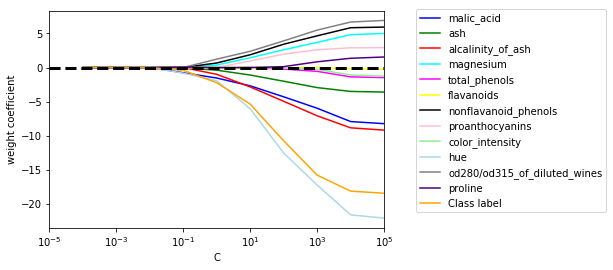

In [52]:
fig = plt.figure()
ax = plt.subplot(111)

colors = ["blue", "green", "red", "cyan", "magenta", "yellow", "black", "pink", "lightgreen", "lightblue", "gray", "indigo", "orange"]

weights, params = [], []
for c in np.arange(-4., 6.0):
    lr = LogisticRegression(penalty="l1", C=10.**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
    
weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(
        params, weights[:, column],
        label=df_wine.columns[column + 1],
        color=color
    )
plt.axhline(0, color="black", linestyle="--", linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel("weight coefficient")
plt.xlabel("C")
plt.xscale("log")
plt.legend(loc="upper left")
ax.legend(loc="upper center", bbox_to_anchor=(1.38, 1.03), ncol=1, fancybox=True)
plt.show()

## Sequential feature selection algorith

In [55]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [65]:
class SBS():
    
    def __init__(
        self, estimator, k_features, scoring=accuracy_score, 
        test_size=0.25, random_state=1
    ):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state
        )
        
        dim = X_train.shape[1] # number of features
        self.indices_ = tuple(range(dim)) # (0, 1, 2, ...)
        self.subsets_ = [ self.indices_ ]
        
        # calculate score for full model
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(
                    X_train, y_train, X_test, y_test, p
                )
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)            
            self.scores_.append(scores[best])
            
            dim -= 1
        
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
        
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [66]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

sbs = SBS(knn, k_features=1)
sbs.fit(X_train, y_train)

In [1]:
k_feat = [ len(k) for k in sbs.subsets_ ]

plt.plot(k_feat, sbs.scores_, marker="o")
plt.ylim([0.7, 1.02])
plt.ylabel("Accuracy")
plt.xlabel("Number of features")
plt.grid()
plt.show()

NameError: name 'sbs' is not defined

In [72]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['malic_acid', 'nonflavanoid_phenols', 'hue'], dtype='object')


In [74]:
knn.fit(X_train_std, y_train)

print("Training accuracy: ", knn.score(X_train_std, y_train))
print("Test accuracy: ", knn.score(X_test_std, y_test))

Training accuracy:  0.967741935484
Test accuracy:  0.962962962963


In [78]:
knn.fit(X_train_std[:,k3], y_train)

print("Training accuracy: ", knn.score(X_train_std[:,k3], y_train))
print("Test accuracy: ", knn.score(X_test_std[:,k3], y_test))

Training accuracy:  0.975806451613
Test accuracy:  0.981481481481


### Assessing feature importance with random forests

In [80]:
from sklearn.ensemble import RandomForestClassifier

In [83]:
feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [86]:
importances = forest.feature_importances_
importances

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) Class label                    0.185453
 2) nonflavanoid_phenols           0.174751
 3) hue                            0.143920
 4) proline                        0.136162
 5) malic_acid                     0.118529
 6) od280/od315_of_diluted_wines   0.058739
 7) flavanoids                     0.050872
 8) total_phenols                  0.031357
 9) ash                            0.025648
10) color_intensity                0.025570
11) magnesium                      0.022366
12) proanthocyanins                0.013354
13) alcalinity_of_ash              0.013279


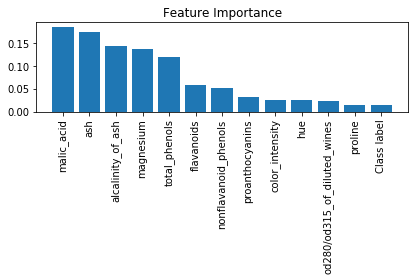

In [93]:
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feat_labels, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()